# Try to do some realistic simulation

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4

In [2]:
import batoid
import numpy as np
import matplotlib.pyplot as plt

In [3]:
telescope = batoid.Optic.fromYaml("ComCamSpiders_z.yaml")

# Make refractive interfaces partially reflective
for surface in telescope.itemDict.values():
        if isinstance(surface, batoid.RefractiveInterface):
            if surface.name.split('_')[0] in ['L1', 'L2', 'L3']:
                surface.forwardCoating = batoid.SimpleCoating(0.004, 0.996)
                surface.reverseCoating = batoid.SimpleCoating(0.004, 0.996)
            elif surface.name.split('_')[0] in ['Filter']:
                surface.forwardCoating = batoid.SimpleCoating(0.04, 0.96)
                surface.reverseCoating = batoid.SimpleCoating(0.04, 0.96)
        if isinstance(surface, batoid.Detector):
            surface.forwardCoating = batoid.SimpleCoating(0.15, 0.85)

In [4]:
# Roation on the telescope
# telescope = telescope.withGlobalRotation(rot=batoid.RotZ(np.radians(0)))

In [5]:
# Initialize variable

# data = theta_x, theta_y, nrad, naz, flux
# nrad = nb de cercle
# naz = nb de points sur chaque cerlce (ramener a un facteur de 6)

# data = [(-0.34, 0.03, 300, 1200, 1.0),(-0.03, 0.2, 100, 1800, 1.0),(0.17, 0.05, 100, 1800, 1.0)] # Optimial pour l'image
data = [(-0.34, 0.03, 1000, 1000, 1.0),(-0.03, 0.2, 1000, 1000, 1.0),(0.17, 0.05, 1000, 1000, 1.0)]

# Rotation
theta = np.radians(-46)

x_prime = []
y_prime = []

for point in data:
    x = point[0]
    y = point[1]
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    
    x_prime.append(x_rot)
    y_prime.append(y_rot)

for i in range(len(data)):
    data[i] = (x_prime[i], y_prime[i], data[i][2], data[i][3], data[i][4])

x, y, flux = [], [], []
debug = False

In [6]:
# Start calculus
for dat in data:

    rays = batoid.RayVector.asPolar(
        optic=telescope, wavelength=830e-9,
        theta_x=np.deg2rad(dat[0]), theta_y=np.deg2rad(dat[1]),
        nrad=dat[2], naz=dat[3], flux=dat[4]
    )

    rForward, rReverse = telescope.traceSplit(rays, minFlux=1e-4, _verbose=False) # _verbose = log calculus

    for i, rr in enumerate(rForward):
        x.append([ix for ix in rr.x])
        y.append([iy for iy in rr.y])
        flux.append([iflux for iflux in rr.flux])

if debug:
    print("# input rays          = {}".format(len(rays)))
    print("# forward output rays = {}".format(sum(len(rr) for rr in rForward)))
    print("# reverse output rays = {}".format(sum(len(rr) for rr in rReverse)))
    print("input flux          = {}".format(np.sum(rays.flux)))
    forwardFlux = np.sum([np.sum(rr.flux) for rr in rForward])
    reverseFlux = np.sum([np.sum(rr.flux) for rr in rReverse])
    print("forward output flux = {}".format(forwardFlux))
    print("reverse output flux = {}".format(reverseFlux))
    print("destroyed flux      = {}".format(
        np.sum(rays.flux) - forwardFlux - reverseFlux
    ))

In [7]:
# Regroup and stock data
x = np.concatenate([ix for ix in x])
y = np.concatenate([iy for iy in y])
flux = np.concatenate([iflux for iflux in flux])

In [8]:
# Rotation
theta = np.radians(46)
x_prime = x*np.cos(theta) - y*np.sin(theta)
y_prime = x*np.sin(theta) + y*np.cos(theta)

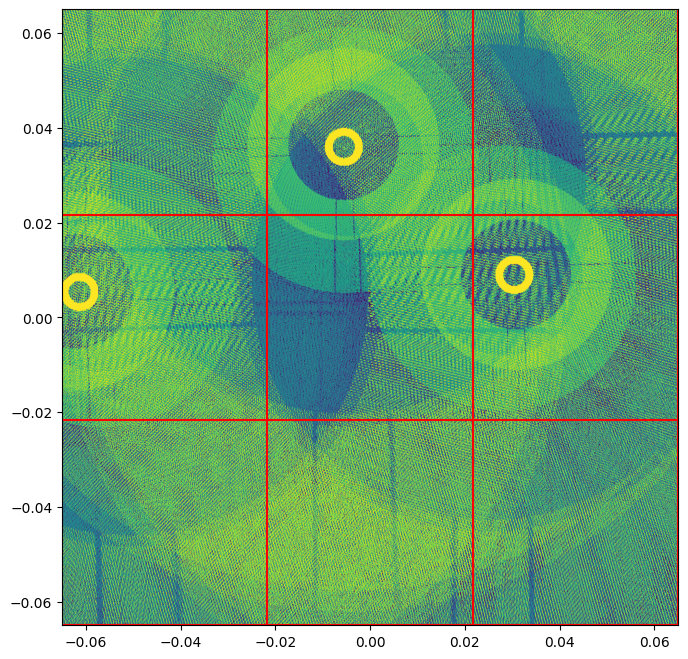

In [13]:
# Do a beautiful plot
CCD_DX = 43.333/1000.
# Définition des intervalles et de l'espacement
x_min, x_max, dx = -CCD_DX*1.5, CCD_DX*1.5, CCD_DX
y_min, y_max, dy = -CCD_DX*1.5, CCD_DX*1.5, CCD_DX

# Générer la grille
x_grid = np.arange(x_min, x_max + dx, dx)
y_grid = np.arange(y_min, y_max + dy, dy)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

# Tracer les lignes verticales
for xi in x_grid:
    ax.plot([xi, xi], [y_min, y_max], c="r")

# Tracer les lignes horizontales
for yi in y_grid:
    ax.plot([x_min, x_max], [yi, yi], c="r")

th = np.linspace(0, 2*np.pi, 1000)
ax.plot(CCD_DX*1.5*np.sqrt(2)*np.cos(th), CCD_DX*1.5*np.sqrt(2)*np.sin(th), c='r', label="Cercle optique")
ax.hexbin(
    x_prime, y_prime, flux,
    reduce_C_function=np.sum, vmax=4e-2, gridsize=2000, bins='log'
)
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")
ax.set_facecolor('black')
plt.show()